# Import Needed Modules

In [1]:
%pip install -q segmentation-models-pytorch

import os
import time
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage.morphology import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_57758/4255182872.py:14: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation
/home/adri/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set device to cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

#### Get all files

In [3]:
files_dir = 'lgg-mri-segmentation/kaggle_3m/'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

#### Read csv file of data

In [4]:
csv_path = 'lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

#### Missing values handling

In [5]:
imputer = SimpleImputer(strategy="most_frequent")

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,2.0,5.0,2,1.0,2.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,2.0,5.0,2,1.0,2.0,2.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


#### Function to get data

In [6]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [7]:
# Show sample
get_file_row('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif')

['TCGA_DU_7010',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif']

#### Store the data into a dataframe

In [8]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_DU_A5TS,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...
1,TCGA_DU_A5TS,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...
2,TCGA_DU_A5TS,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...
3,TCGA_DU_A5TS,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...
4,TCGA_DU_A5TS,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...
...,...,...,...
3924,TCGA_DU_7019,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...
3925,TCGA_DU_7019,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...
3926,TCGA_DU_7019,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...
3927,TCGA_DU_7019,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19...


## Dataset Class

In [9]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [10]:
df = pd.merge(df, filenames_df, on="Patient")

### Split data into train, valid, and test

In [11]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, valid_df = train_test_split(test_df, test_size=0.5)

### Transforming
- Only applied channel dropout and random color changes, the model gave subpar results when confronted with rotations and flips.

In [12]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

### DataLoaders

In [13]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

#### Show sample

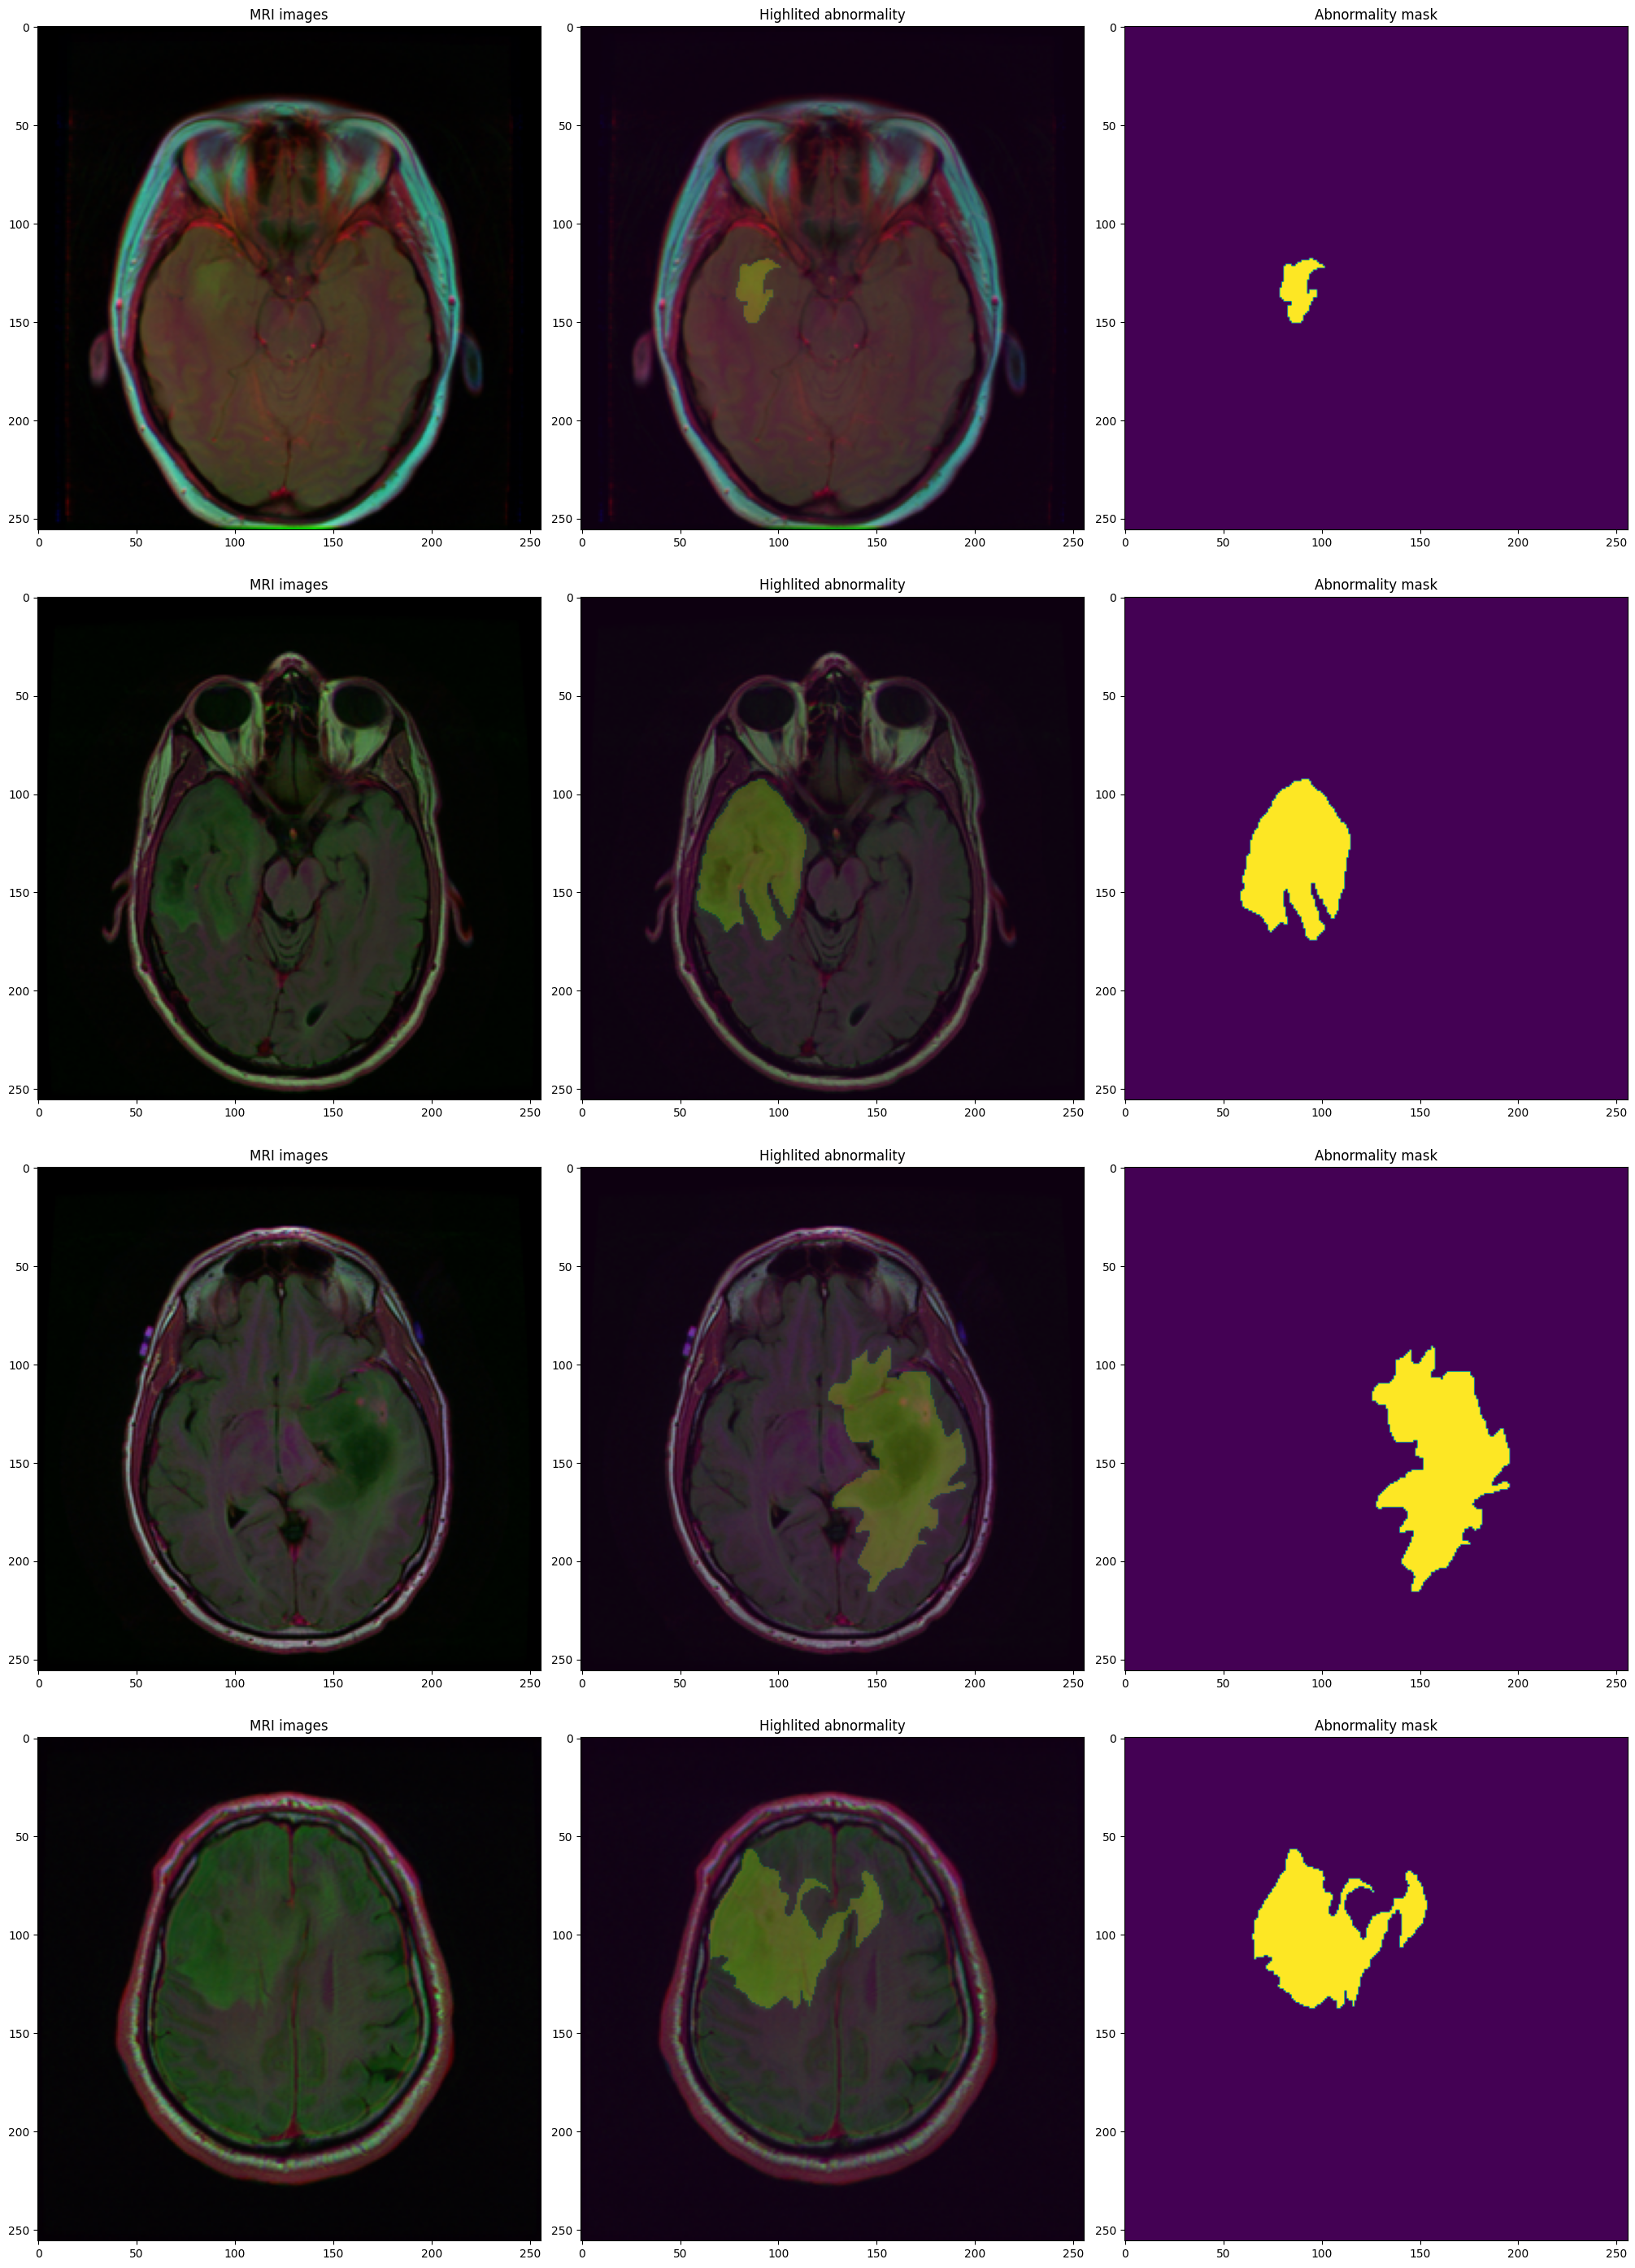

In [14]:
%matplotlib inline
n_examples = 4

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break
        
    
    